In [1]:
import cv2
import mediapipe as mp
import glob
import os

# Initialize MediaPipe solutions for hands and face
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=True)
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, static_image_mode=True)

# Directory containing images
image_dir = 'D:/image_dataset/face_touch'
# Directory to save processed images
processed_image_dir = 'path/to/save/processed/images'
os.makedirs(processed_image_dir, exist_ok=True)

image_files = glob.glob(os.path.join(image_dir, '*.png')) + glob.glob(os.path.join(image_dir, '*.jpg'))  # Adjust pattern as needed


for image_path in image_files:
    image = cv2.imread(image_path)
    if image is None:
        continue
    
    # Convert the BGR image to RGB and process with MediaPipe
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hand_results = hands.process(image_rgb)
    face_results = face_mesh.process(image_rgb)
    
    # Draw the hand landmarks
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if hand_results.multi_hand_landmarks:
        for hand_landmarks in hand_results.multi_hand_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Check if any hand is close to the face
    touching_face = False
    if hand_results.multi_hand_landmarks and face_results.multi_face_landmarks:
        for face_landmarks in face_results.multi_face_landmarks:
            for hand_landmarks in hand_results.multi_hand_landmarks:
                for landmark in hand_landmarks.landmark:
                    x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
                    for face_landmark in face_landmarks.landmark:
                        fx, fy = int(face_landmark.x * image.shape[1]), int(face_landmark.y * image.shape[0])
                        # Adjust the threshold value as needed
                        if abs(fx - x) < 40 and abs(fy - y) < 40:
                            touching_face = True
                            break
                    if touching_face:
                        break
            if touching_face:
                break

    # Display the message if hand is close to the face
    if touching_face:
        cv2.putText(image, 'You are touching your face!', (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    # Save the processed image
    processed_image_path = os.path.join(processed_image_dir, os.path.basename(image_path))
    cv2.imwrite(processed_image_path, image)

hands.close()
face_mesh.close()


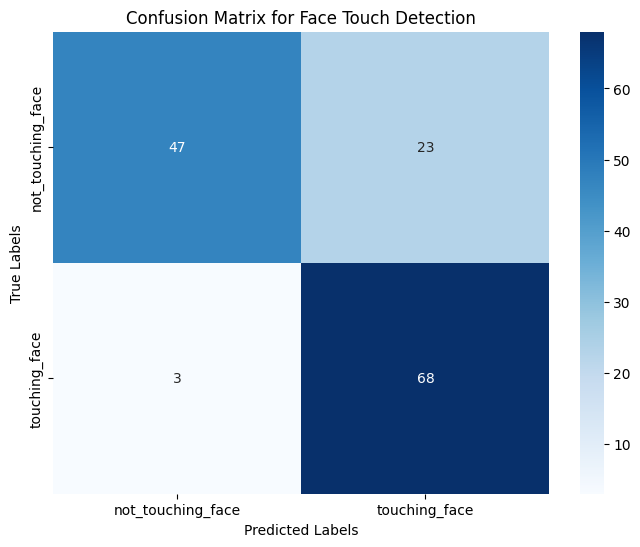

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import glob
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Initialize MediaPipe solutions
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=True)
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, static_image_mode=True)

# Base directory of images
base_dir = 'D:/image_dataset/face_touch'

# Assuming two folders in the base directory: 'touching_face' and 'not_touching_face'
touching_face_dir = os.path.join(base_dir, 'touching_face')
not_touching_face_dir = os.path.join(base_dir, 'not_touching_face')

def process_image(image_path):
    """Process the image and predict if the face is being touched."""
    image = cv2.imread(image_path)
    if image is None:
        return None
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Process with MediaPipe
    hand_results = hands.process(image_rgb)
    face_results = face_mesh.process(image_rgb)
    
    # Determine if any hand is close to the face
    touching_face = False
    if hand_results.multi_hand_landmarks and face_results.multi_face_landmarks:
        for face_landmarks in face_results.multi_face_landmarks:
            for hand_landmarks in hand_results.multi_hand_landmarks:
                for landmark in hand_landmarks.landmark:
                    x, y = landmark.x, landmark.y
                    for face_landmark in face_landmarks.landmark:
                        fx, fy = face_landmark.x, face_landmark.y
                        # Adjust threshold value as needed
                        if abs(fx - x) < 0.1 and abs(fy - y) < 0.1:
                            touching_face = True
                            break
                    if touching_face:
                        break
            if touching_face:
                break
                
    return 'touching_face' if touching_face else 'not_touching_face'
    

def evaluate_images(images_dir, true_label):
    predictions = []
    for image_path in glob.glob(os.path.join(images_dir, '*.png')) + glob.glob(os.path.join(images_dir, '*.jpg')):  # Include other formats if needed
        prediction = process_image(image_path)
        if prediction:
            predictions.append((true_label, prediction))
    return predictions

# Process images and evaluate
touching_face_predictions = evaluate_images(touching_face_dir, 'touching_face')
not_touching_face_predictions = evaluate_images(not_touching_face_dir, 'not_touching_face')

all_predictions = touching_face_predictions + not_touching_face_predictions

# Extract true labels and predicted labels
true_labels, predicted_labels = zip(*all_predictions)

# Encode labels
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)
predicted_labels_encoded = label_encoder.transform(predicted_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels_encoded, predicted_labels_encoded)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Face Touch Detection')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(true_labels_encoded, predicted_labels_encoded)
precision = precision_score(true_labels_encoded, predicted_labels_encoded, average='macro')
recall = recall_score(true_labels_encoded, predicted_labels_encoded, average='macro')
f1 = f1_score(true_labels_encoded, predicted_labels_encoded, average='macro')

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8156028368794326
Precision: 0.8436263736263736
Recall: 0.8145875251509054
F1 Score: 0.8114197530864196


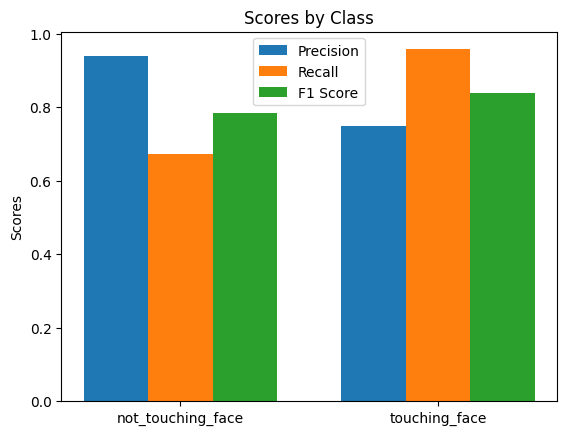

In [4]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

metrics = precision_recall_fscore_support(true_labels_encoded, predicted_labels_encoded, average=None, labels=np.unique(true_labels_encoded))
precision, recall, f1, _ = metrics

# For plotting
categories = label_encoder.classes_

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by Class')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.show()


In [15]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming true_labels_encoded and predicted_labels_encoded are defined elsewhere
# Also assuming label_encoder is already fitted to your classes

metrics = precision_recall_fscore_support(true_labels_encoded, predicted_labels_encoded, average=None, labels=np.unique(true_labels_encoded))
precision, recall, f1, _ = metrics

# Calculate overall accuracy
accuracy = accuracy_score(true_labels_encoded, predicted_labels_encoded)

# For printing metrics by class
categories = label_encoder.classes_

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nScores by Class:")
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f" Precision: {precision[i]:.2f}")
    print(f" Recall: {recall[i]:.2f}")
    print(f" F1 Score: {f1[i]:.2f}\n")



Accuracy: 81.56%

Scores by Class:
Class: not_touching_face
 Precision: 0.94
 Recall: 0.67
 F1 Score: 0.78

Class: touching_face
 Precision: 0.75
 Recall: 0.96
 F1 Score: 0.84



In [16]:
from sklearn.metrics import classification_report
print(classification_report(true_labels_encoded, predicted_labels_encoded, target_names=label_encoder.classes_))

                   precision    recall  f1-score   support

not_touching_face       0.94      0.67      0.78        70
    touching_face       0.75      0.96      0.84        71

         accuracy                           0.82       141
        macro avg       0.84      0.81      0.81       141
     weighted avg       0.84      0.82      0.81       141



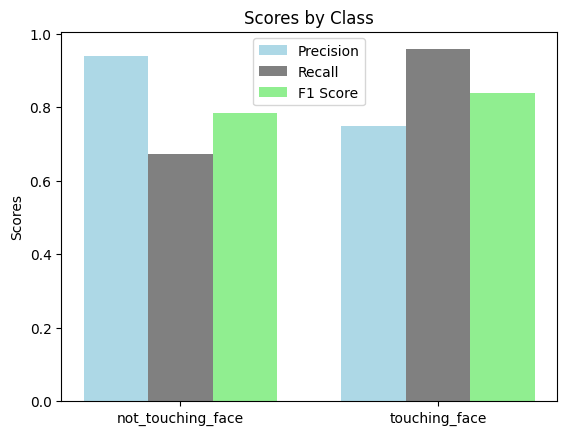

In [14]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Assuming true_labels_encoded, predicted_labels_encoded, and label_encoder are defined elsewhere

metrics = precision_recall_fscore_support(true_labels_encoded, predicted_labels_encoded, average=None, labels=np.unique(true_labels_encoded))
precision, recall, f1, _ = metrics

# For plotting
categories = label_encoder.classes_

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots()
# Adjusting the colors here
rects1 = ax.bar(x - width, precision, width, label='Precision', color='lightblue')
rects2 = ax.bar(x, recall, width, label='Recall', color='grey')
rects3 = ax.bar(x + width, f1, width, label='F1 Score', color='lightgreen')

ax.set_ylabel('Scores')
ax.set_title('Scores by Class')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.show()
